In [3]:
import os
import sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
sys.path.append("../")

import torch
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import numpy as np
from scipy import ndimage
from skimage.measure import shannon_entropy
import pandas as pd
import cv2
import json
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from model import build_model
from clip_ import load, tokenize, similarity_score
from vit_cam import interpret_vit, interpret_vit_overlapped, vit_relevance
from rn_cam import interpret_rn, interpret_rn_overlapped, rn_relevance
sys.path.append("../pytorch-grad-cam")
from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad

from pickle_loader import Pickle_data_loader

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
model_rn, preprocess = load("RN101", device=device, jit=False)
model_vit, preprocess = load("ViT-B/32", device=device, jit=False)

In [6]:
model_types = ["ViT", "ResNet"] 

font = {
    'size': 15,
}

ori_preprocess = Compose([
        Resize((224), interpolation=Image.BICUBIC),
        CenterCrop(size=(224, 224)),
        ToTensor()])

vit_emotion_dict = json.load(open("ViT_ARTEMIS_EMOTIONS.json"))
resnet__emotion_dict = json.load(open("ResNet_ARTEMIS_EMOTIONS.json"))

emotion_dicts = {"ViT":vit_emotion_dict, "ResNet":resnet__emotion_dict}

artemis_labels = vit_emotion_dict.keys()

ARTEMIS_EMOTIONS = { 'amusement':0,
                     'awe':1,
                     'contentment':2,
                     'excitement':3,
                     'anger':4,
                     'disgust':5,
                     'fear':6,
                     'sadness':7,
                     'something else':8}

root = "../../Images/"
res_dir = "../../results/artemis_emotions/"

if not os.path.exists(res_dir):
    os.mkdir(res_dir)

# Saliency visualization for Artemis images 

In [9]:
image_loader = Pickle_data_loader(root+"wikiart/", 40)
for i,batch in enumerate(image_loader):
    if i==0:
        image_list = batch["image"]
        label_list = batch["label"]
    else:
        image_list = torch.cat((image_list, batch["image"]), dim=0)
        label_list = torch.cat((label_list, batch["label"]), dim=0)

/home/mamooler/miniconda/envs/habitat/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


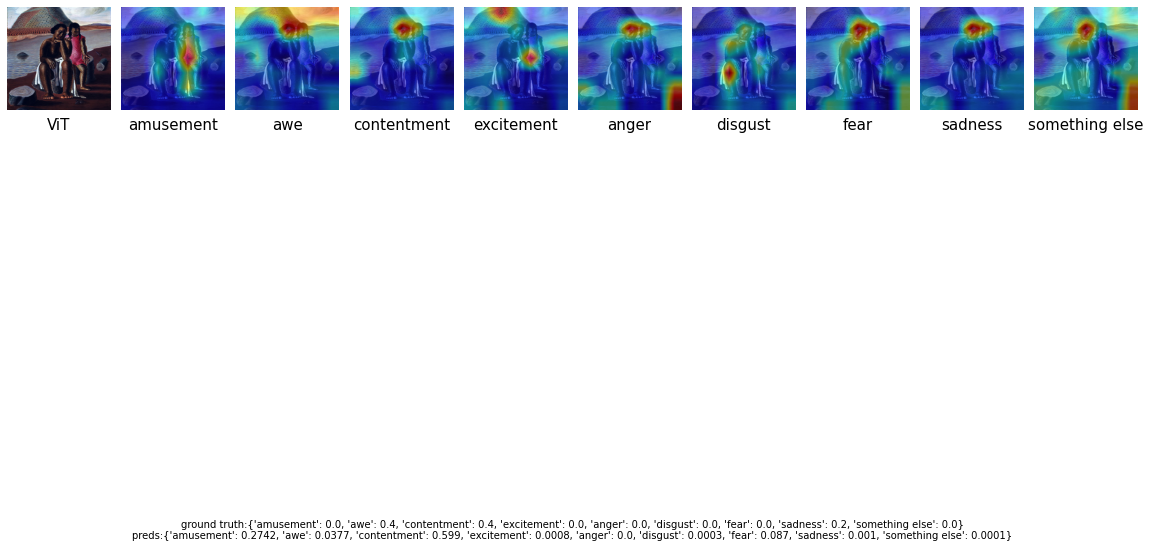

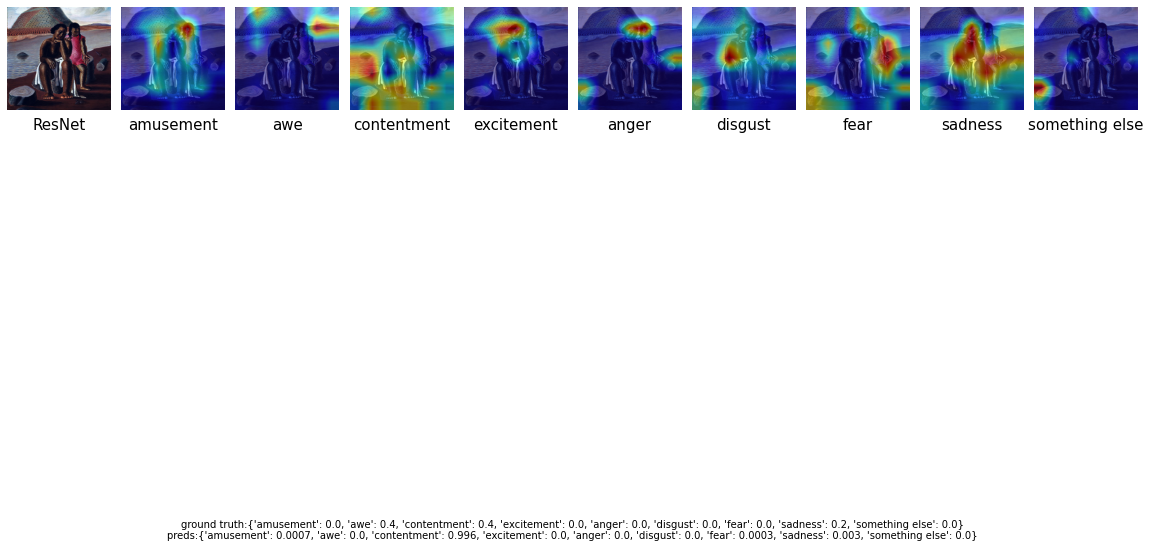

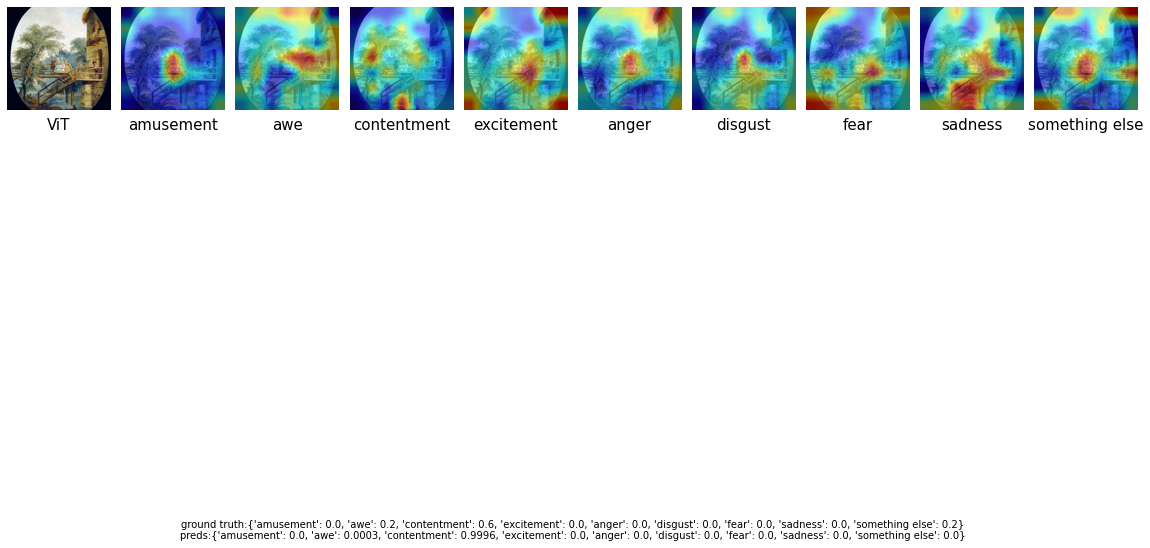

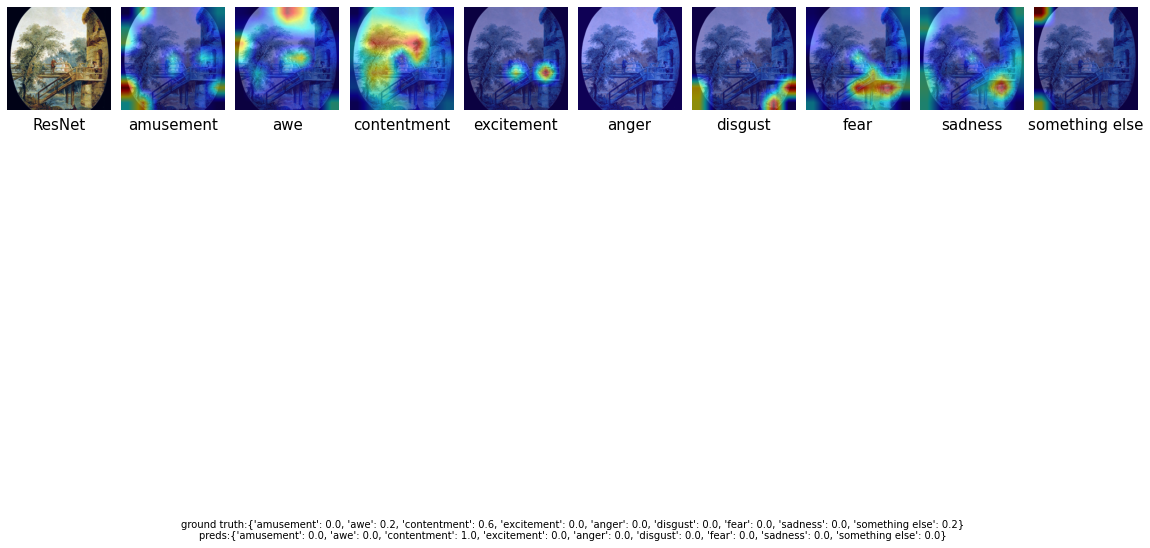

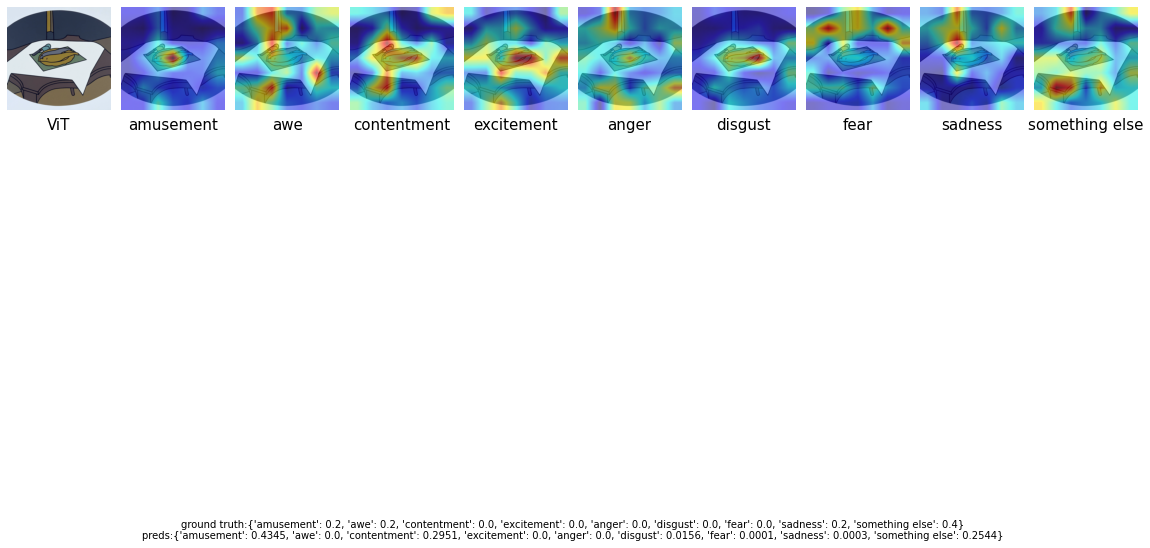

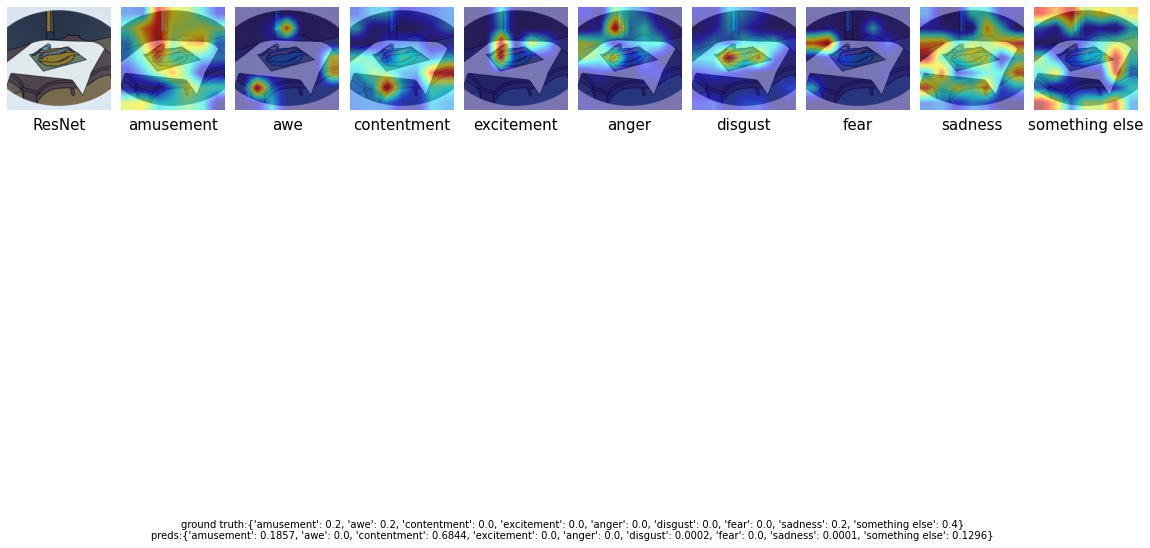

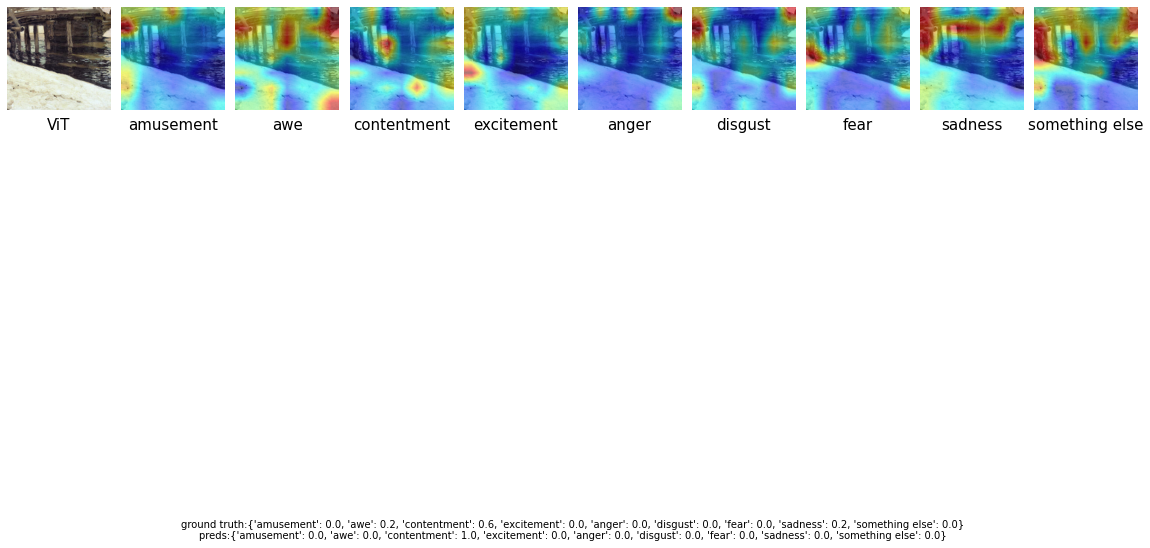

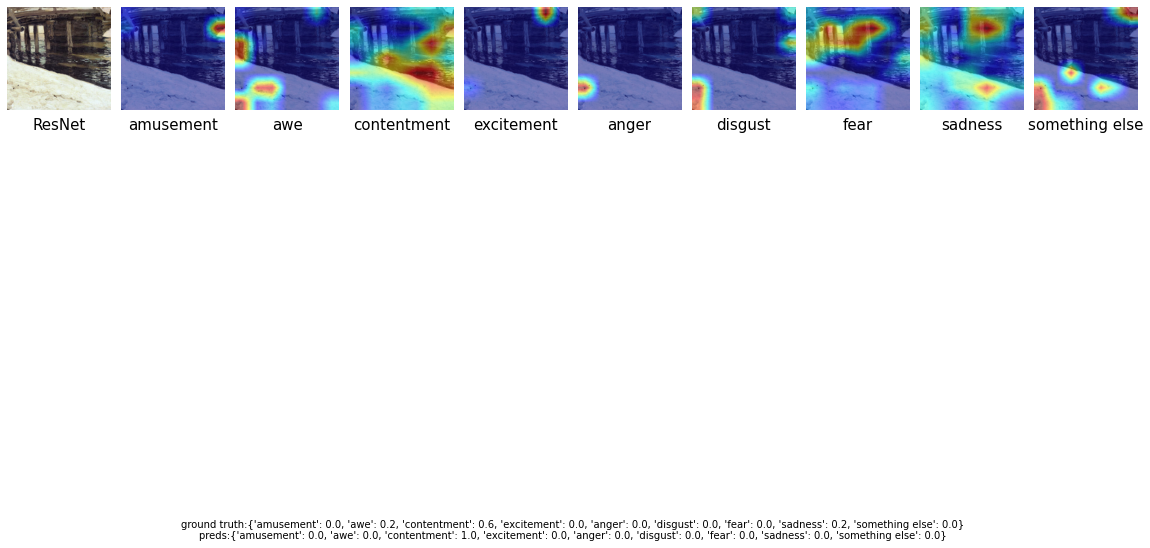

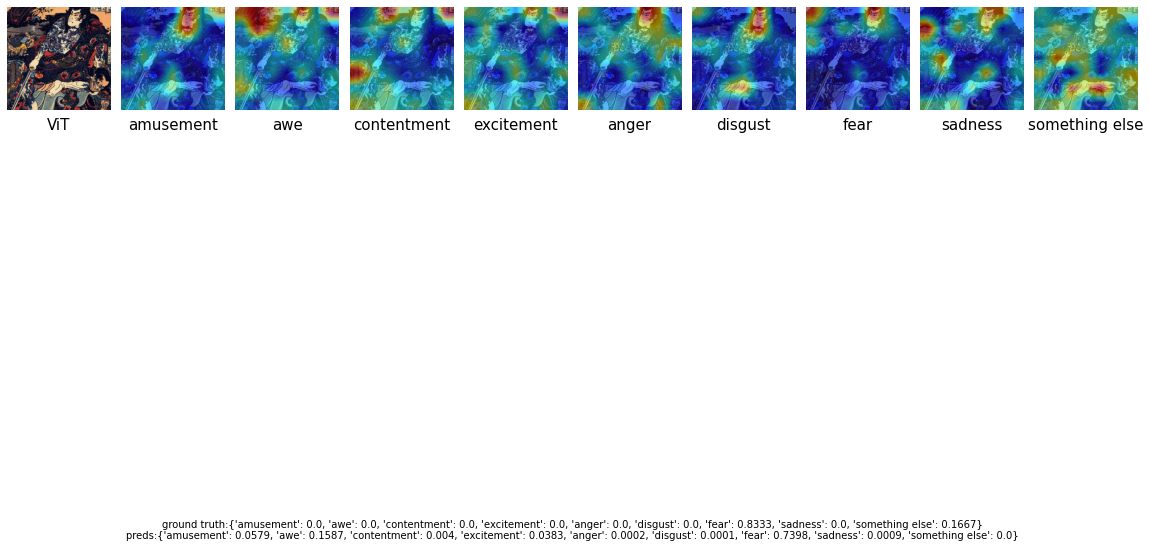

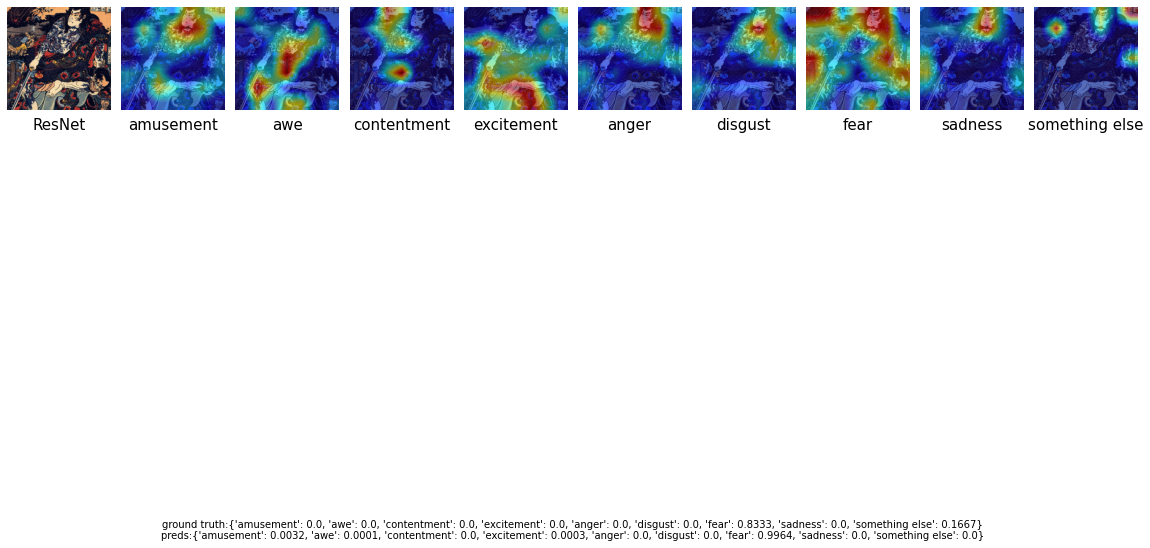

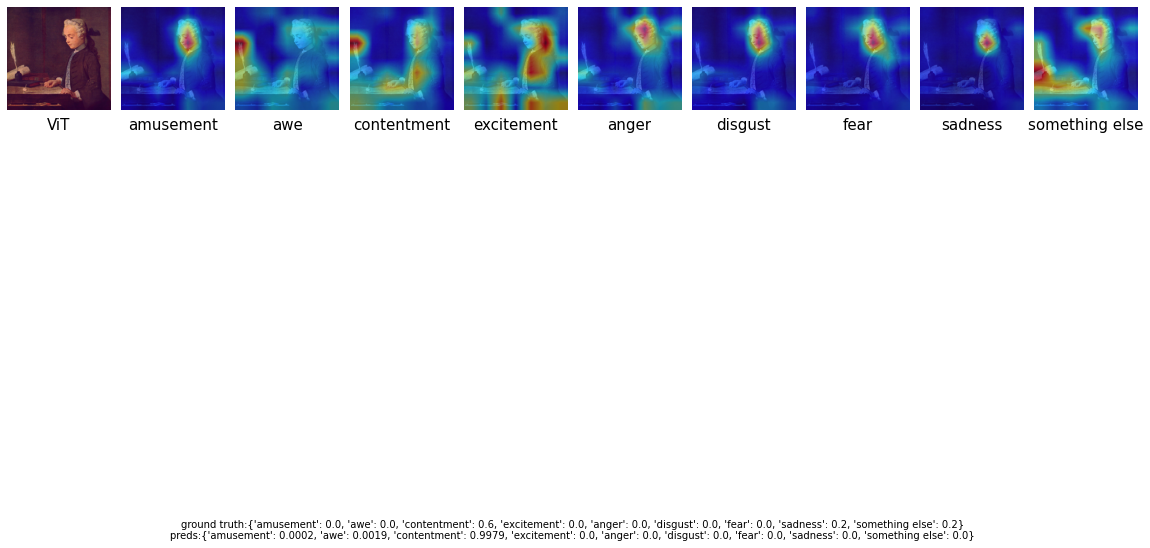

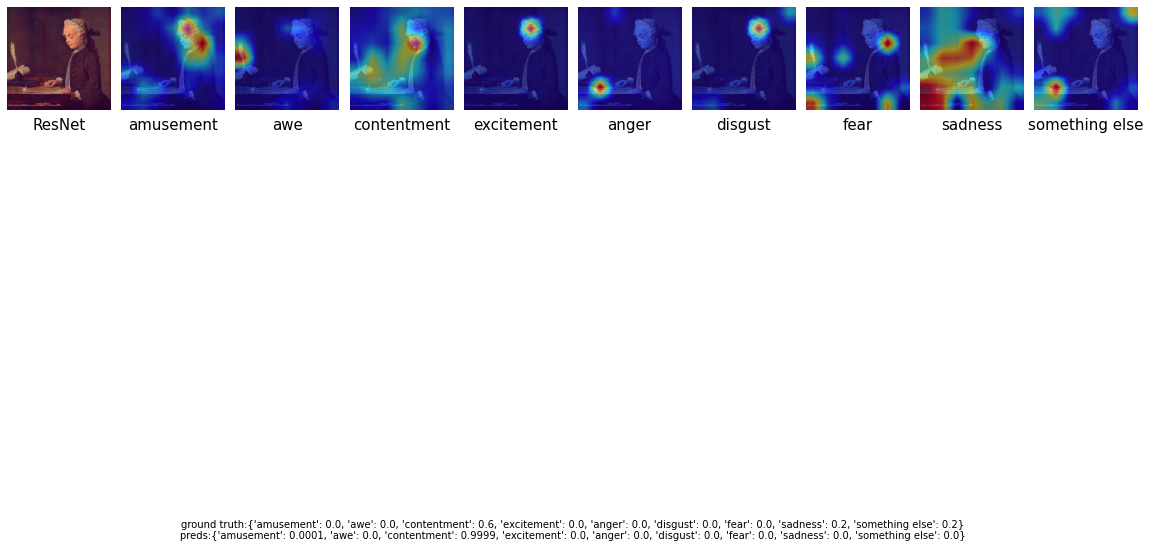

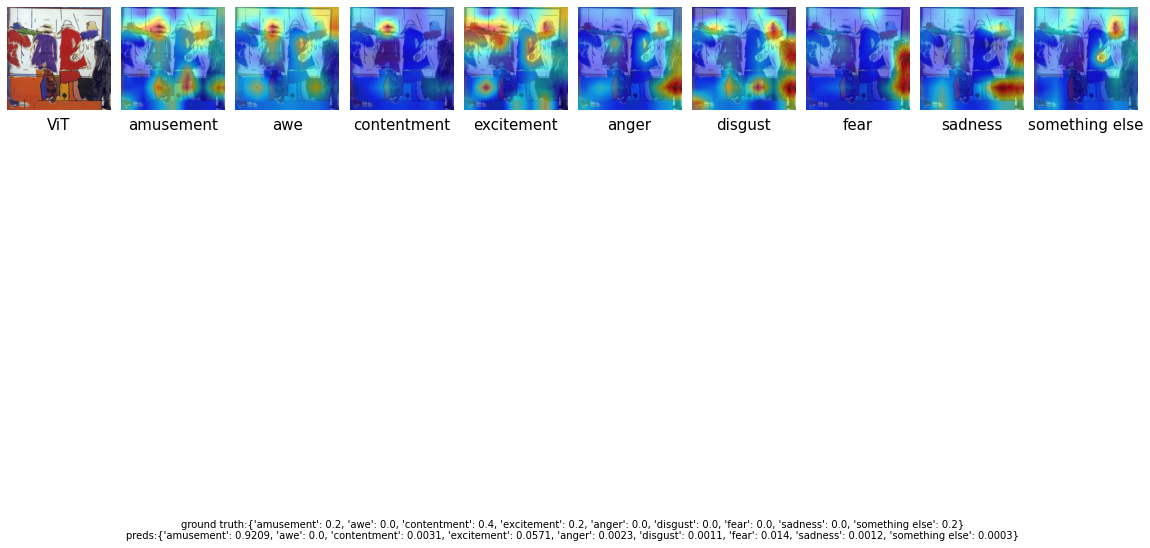

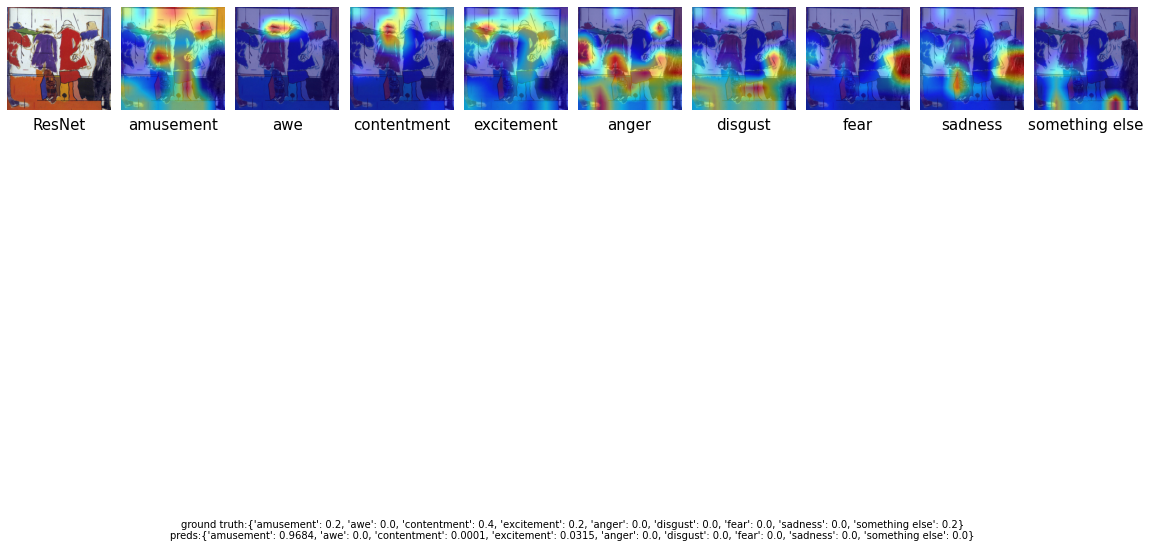

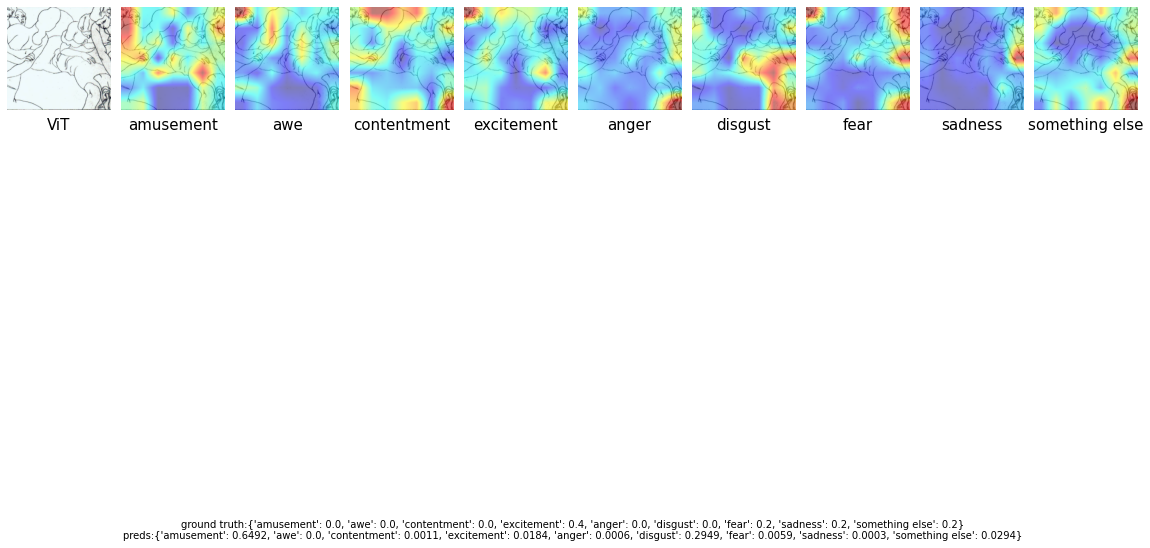

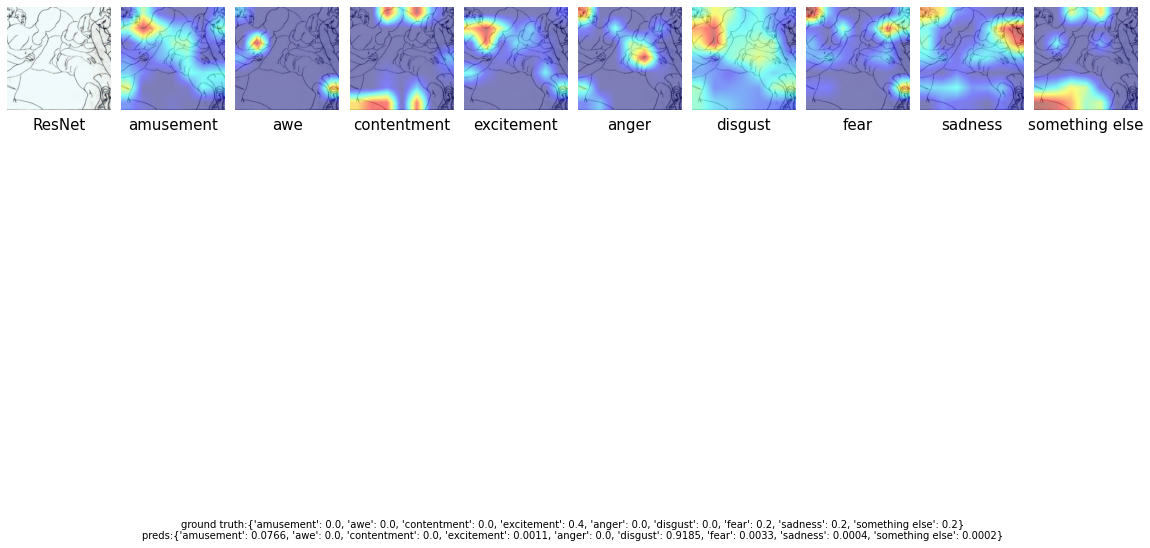

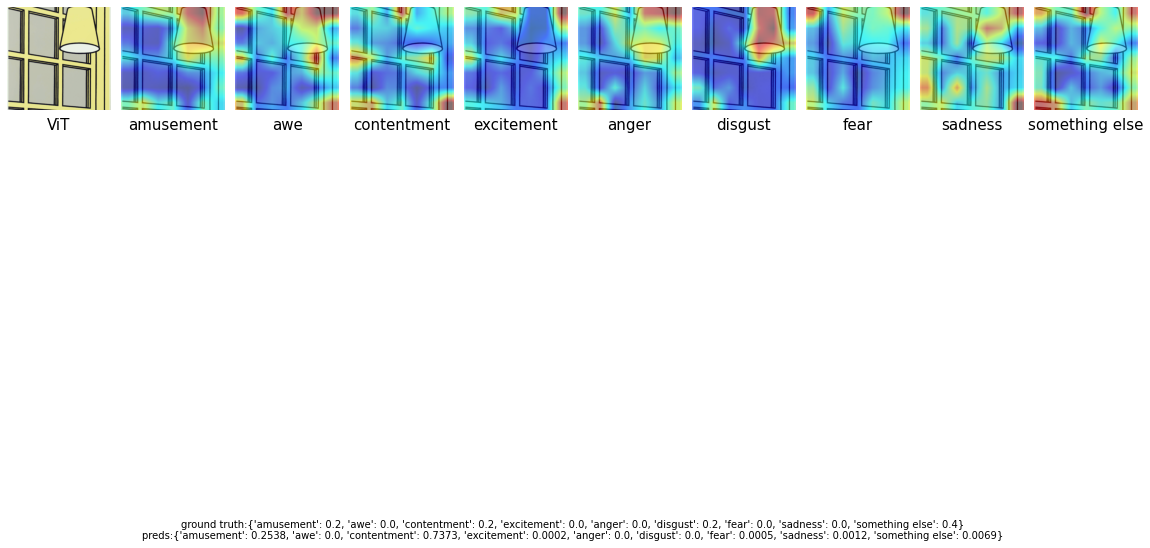

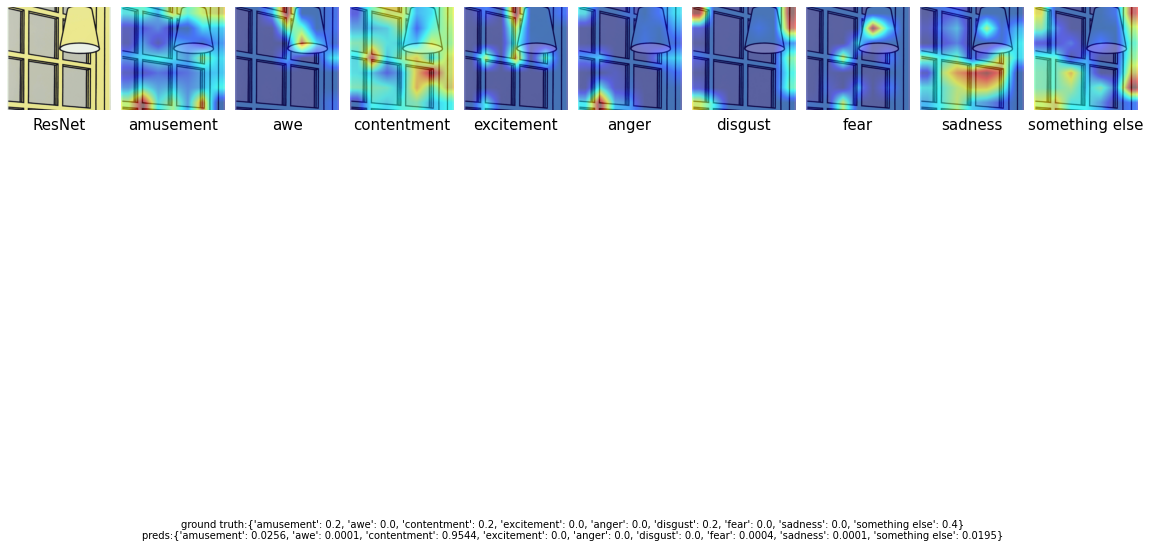

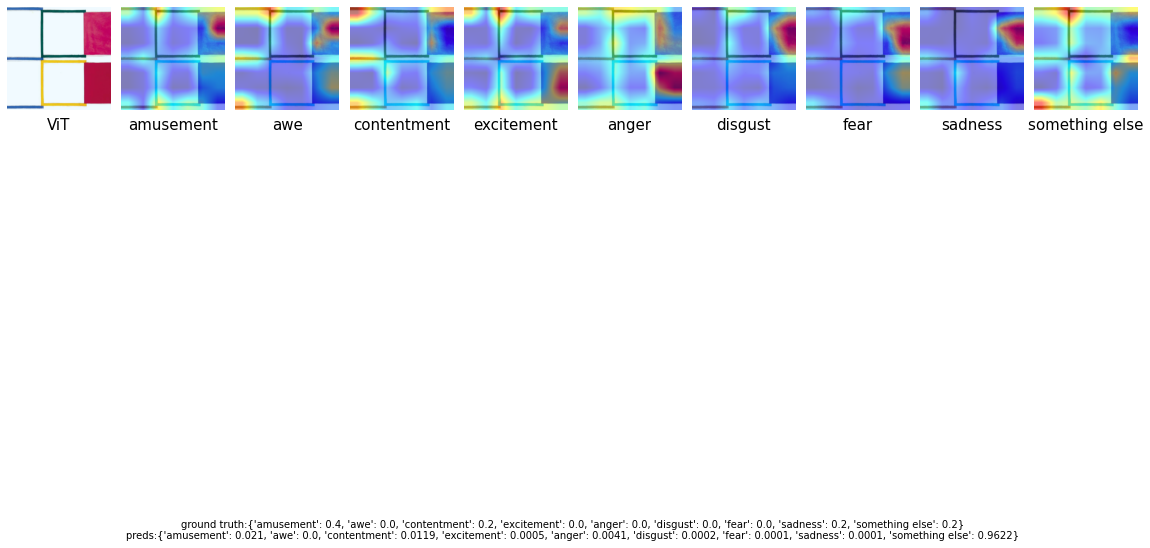

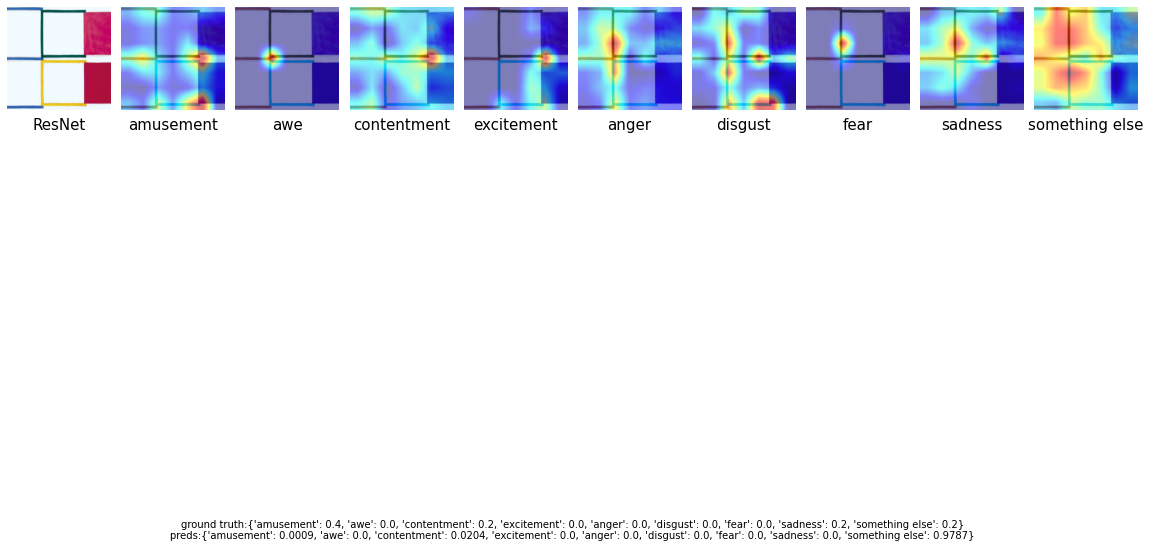

In [15]:
pp = PdfPages(res_dir+'artemis.pdf')

def tensor2img(tensor):
    tensor = tensor.detach().cpu()
    c = tensor-tensor.min()
    c /= c.max()
    return c.permute(1,2,0)

for id_, image in enumerate(image_list[:10]):
    
    image = image.unsqueeze(0).to(device)
    label_dict = {}
    for key, val in ARTEMIS_EMOTIONS.items():
        label_dict[key] = round(float(label_list[id_][val].item()), 4)

    for neg in [False]:
         
        for model_id, model_type in enumerate(model_types):
            

            plt.figure(figsize=(16, 16))
            
            plt.subplot(1,10,1)
            plt.axis('off')
            plt.tight_layout()
            plt.imshow(tensor2img(image[0]))
            
            caption = ""
            for key, val in label_dict.items():
                if val>0:
                    caption+=f"{key}:{round(float(val), 4)}\n"

            if neg==None: title = "\n overlapped  \n blue:neg, red: pos"
            elif neg==True: title = "\n negative \n blue: high, red: low"
            else: title = "\n positive \n blue:low, red:high"
            
            plt.title(model_type, **font, y=-0.25)


            subplot = 2
            scores = []

            for emotion, emotion_feature in emotion_dicts[model_type].items():

                emotion_feature = torch.HalfTensor(emotion_feature).unsqueeze(dim=0).to(device)

                plt.subplot(1,10, subplot)
                plt.axis('off')
                plt.tight_layout()
                subplot+=1

                if model_type=="ViT":
                    score = similarity_score(model_vit, image, emotion_feature)
                    if not neg==None:

                        interpret_vit(image.type(model_vit.dtype), emotion_feature, model_vit.visual, device, neg_saliency=neg)
                    else:
                        interpret_vit_overlapped(image.type(model_vit.dtype), emotion_feature, model_vit.visual, device)

                else:
                    score = similarity_score(model_rn, image, emotion_feature)
                    if not neg==None:
                        interpret_rn(image.type(model_rn.dtype), emotion_feature, model_rn.visual, GradCAM, device, neg_saliency=neg)
                    else:
                        interpret_rn_overlapped(image.type(model_rn.dtype), emotion_feature, model_rn.visual, GradCAM, device)

                scores.append(score.item())

               
                plt.title(emotion, **font,y=-0.25)
                

            scores = torch.tensor(scores)
            scores = torch.nn.functional.softmax(scores)
            preds = {}
            for key, val in ARTEMIS_EMOTIONS.items():
                preds[key] = round(float(scores[val].item()), 4) 

            plt.figtext(0.5, 0.1, f'ground truth:{label_dict}\npreds:{preds}', wrap=True, verticalalignment='top', horizontalalignment='center', fontsize=10)
            plt.savefig(res_dir + f'{model_type}_{id_}.png')
            pp.savefig()
        
pp.close()

In [10]:
img_ids = ['scary_painting_colorful.jpg', "artemis.jpg", "sad_woman.jpg", "sad_painting.jpg"]

/home/mamooler/miniconda/envs/habitat/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


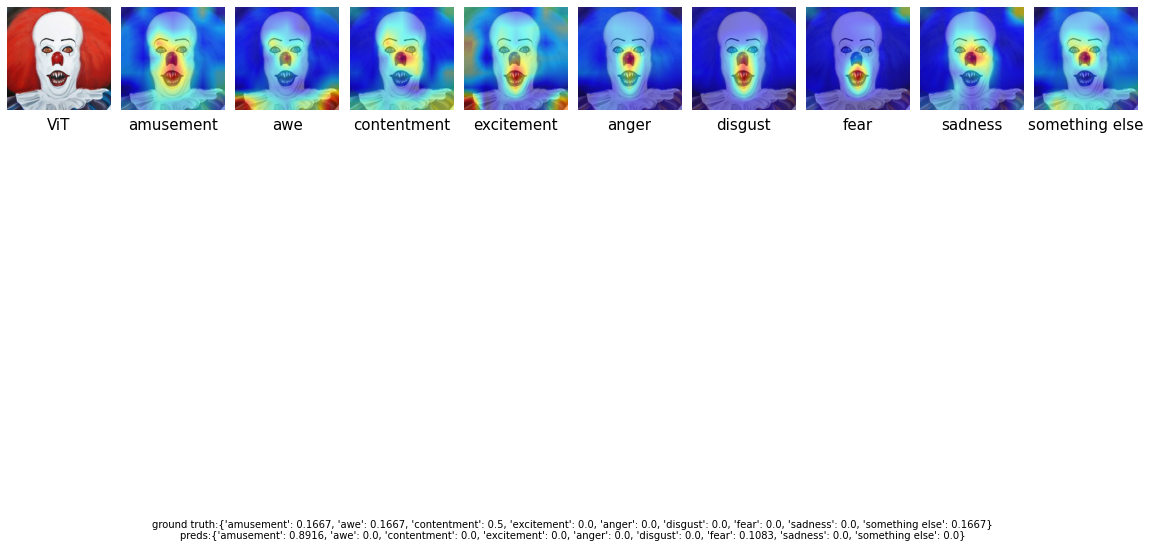

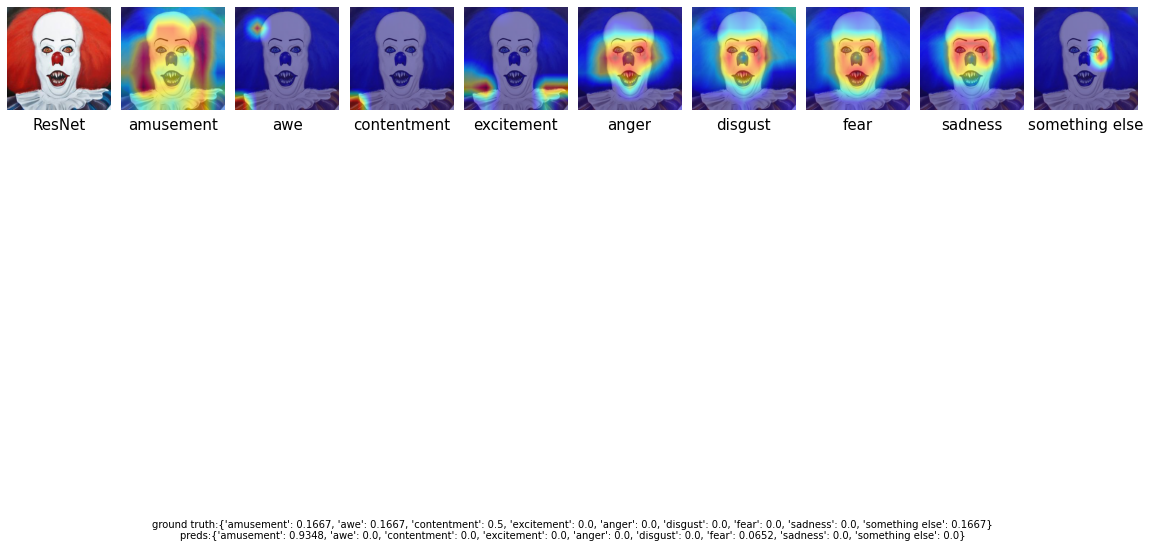

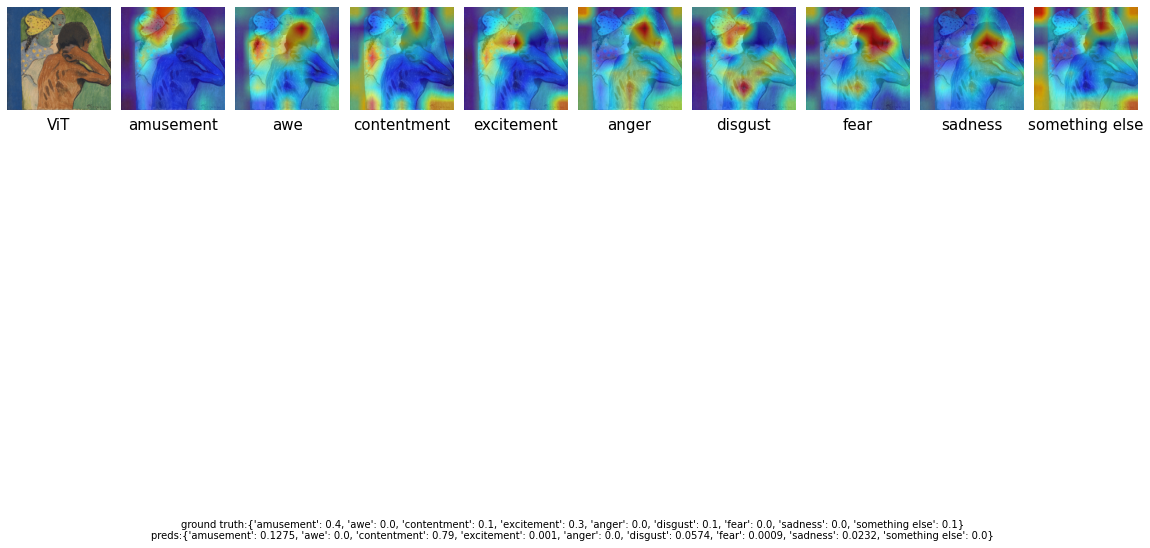

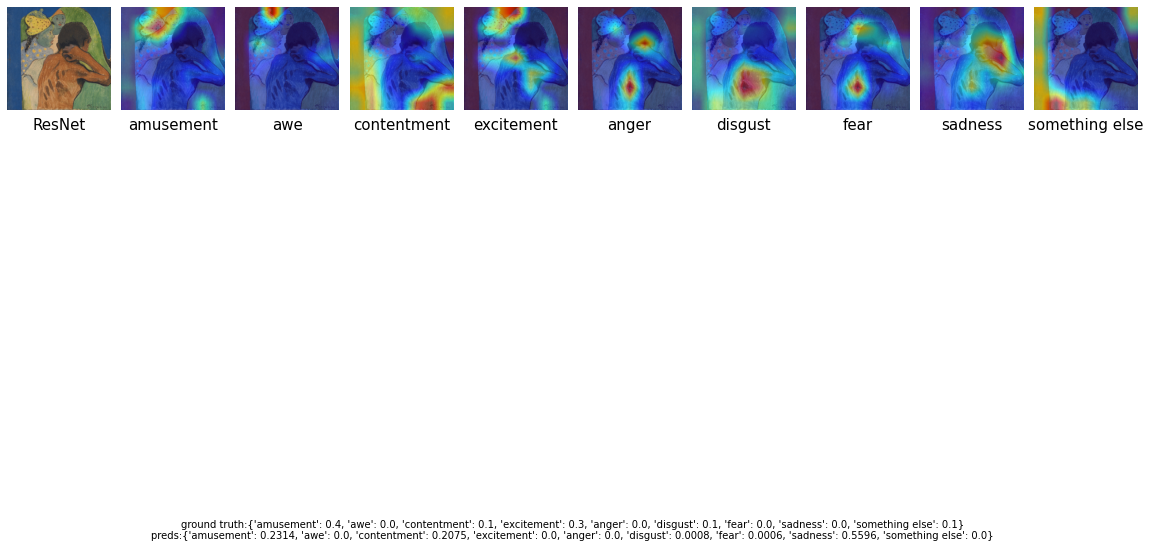

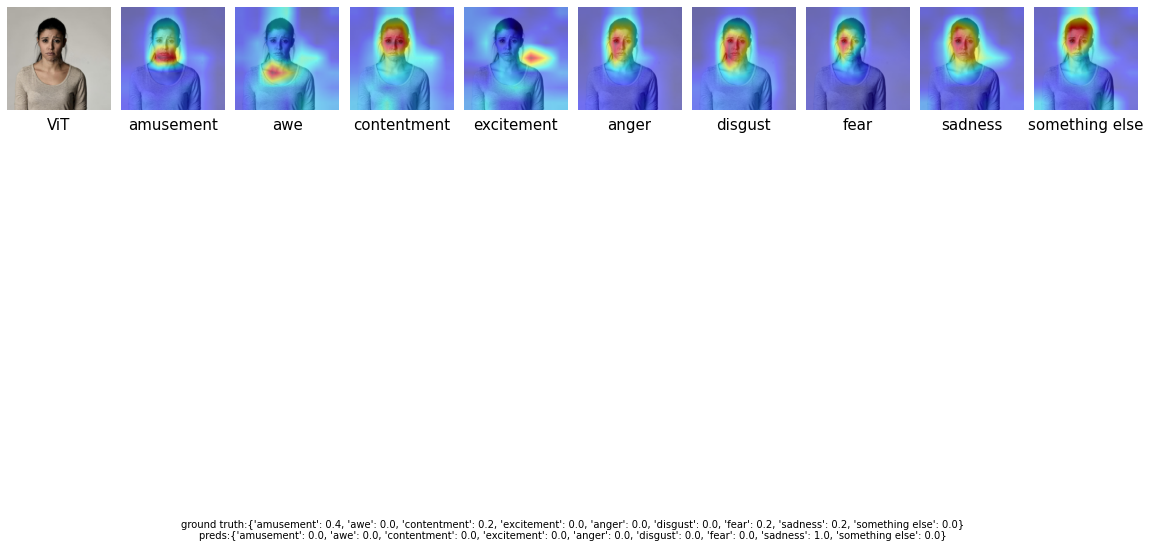

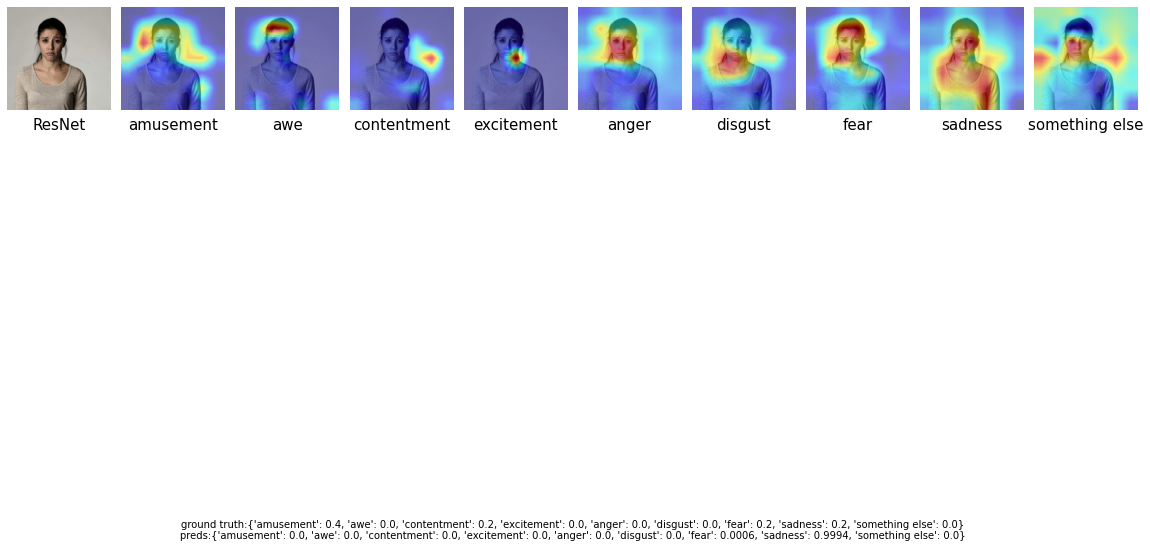

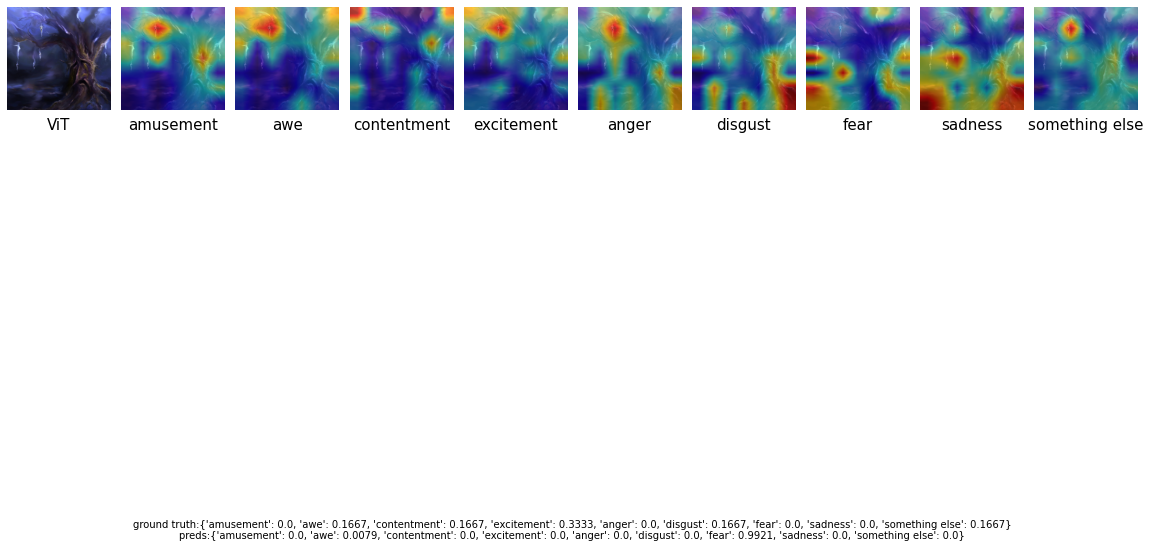

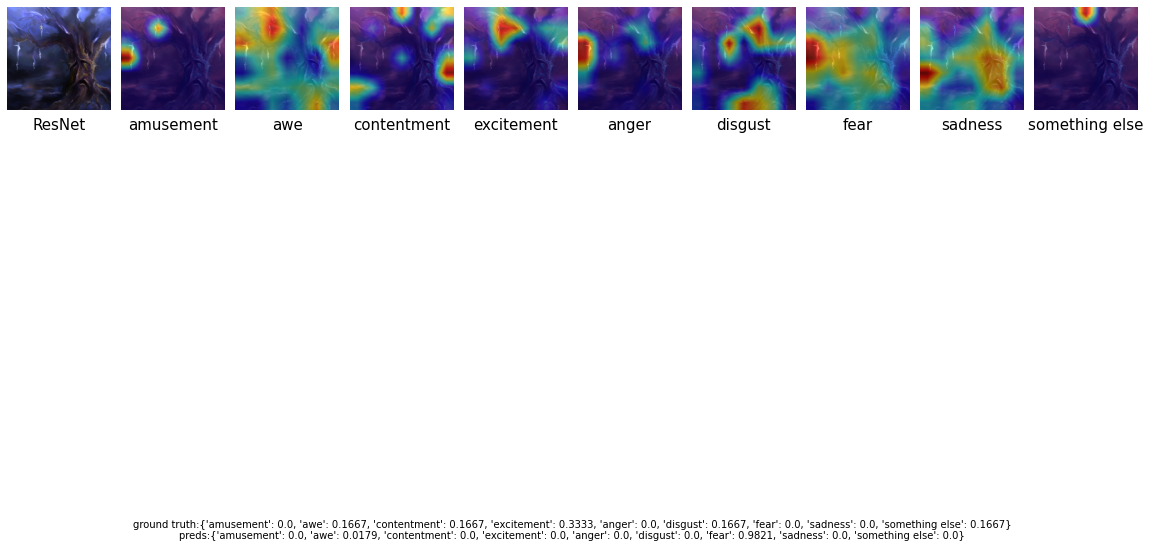

In [12]:
for id_, img_id in enumerate(img_ids):
    
    img_path =  os.path.join(root, img_id )
    image = ori_preprocess(Image.open(img_path))
    p_image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

    
    label_dict = {}
    for key, val in ARTEMIS_EMOTIONS.items():
        label_dict[key] = round(float(label_list[id_][val].item()), 4)

    for neg in [False]:
         
        for model_id, model_type in enumerate(model_types):
            

            plt.figure(figsize=(16, 16))
            plt.subplot(1,10,1)
            plt.tight_layout()
            plt.axis('off')
            plt.imshow(image.permute(1, 2, 0))
           
            
            caption = ""
            for key, val in label_dict.items():
                if val>0:
                    caption+=f"{key}:{round(float(val), 4)}\n"

            if neg==None: title = "\n overlapped  \n blue:neg, red: pos"
            elif neg==True: title = "\n negative \n blue: high, red: low"
            else: title = "\n positive \n blue:low, red:high"
            
            plt.title(model_type, **font, y=-0.25)


            subplot = 2
            scores = []

            for emotion, emotion_feature in emotion_dicts[model_type].items():

                emotion_feature = torch.HalfTensor(emotion_feature).unsqueeze(dim=0).to(device).detach()

                plt.subplot(1,10, subplot)
                plt.axis('off')
                plt.tight_layout()
                subplot+=1

                if model_type=="ViT":
                    score = similarity_score(model_vit, p_image, emotion_feature)
                    if not neg==None:

                        interpret_vit(p_image.type(model_vit.dtype), emotion_feature, model_vit.visual, device, neg_saliency=neg)
                    else:
                        interpret_vit_overlapped(p_image.type(model_vit.dtype), emotion_feature, model_vit.visual, device)

                else:
                    score = similarity_score(model_rn, p_image, emotion_feature)
                    if not neg==None:
                        interpret_rn(p_image.type(model_rn.dtype), emotion_feature, model_rn.visual, GradCAM, device, neg_saliency=neg)
                    else:
                        interpret_rn_overlapped(p_image.type(model_rn.dtype), emotion_feature, model_rn.visual, GradCAM, device)

                scores.append(score.item())

               
                plt.title(emotion, **font,y=-0.25)
                

            scores = torch.tensor(scores)
            scores = torch.nn.functional.softmax(scores)
            preds = {}
            for key, val in ARTEMIS_EMOTIONS.items():
                preds[key] = round(float(scores[val].item()), 4) 

            plt.figtext(0.5, 0.1, f'ground truth:{label_dict}\npreds:{preds}', wrap=True, verticalalignment='top', horizontalalignment='center', fontsize=10)
            plt.savefig(res_dir + f'{model_type}_{id_}.png')
          

# Attention mean and variance for each emotion

In [21]:
image_loader = Pickle_data_loader(root+"wikiart/", 1000)
for i,batch in enumerate(image_loader):
    if i==0:
        image_list = batch["image"]
        label_list = batch["label"]
    else:
        image_list = torch.cat((image_list, batch["image"]), dim=0)
        label_list = torch.cat((label_list, batch["label"]), dim=0)

amusement


/home/mamooler/miniconda/envs/habitat/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


variance: 0.030917884048150508 
 entropy: 11.097100222626185
awe
variance: 0.030385672433035714 
 entropy: 10.868053568805596
contentment
variance: 0.029428681042729592 
 entropy: 10.899822475522045
excitement
variance: 0.03097011519451531 
 entropy: 10.908475082906211
anger
variance: 0.029620097257653064 
 entropy: 10.788330990830142
disgust
variance: 0.03029457310267857 
 entropy: 11.004966926823633
fear
variance: 0.02787876175860969 
 entropy: 10.943962247873129
sadness
variance: 0.028710538903061227 
 entropy: 10.882715433551475
something else
variance: 0.02890889568718112 
 entropy: 10.680863934252509
          emotion  variance    entropy
0       amusement  0.030918  11.097100
1             awe  0.030386  10.868054
2     contentment  0.029429  10.899822
3      excitement  0.030970  10.908475
4           anger  0.029620  10.788331
5         disgust  0.030295  11.004967
6            fear  0.027879  10.943962
7         sadness  0.028711  10.882715
8  something else  0.028909  10.680

/home/mamooler/miniconda/envs/habitat/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


variance: 0.032231844608272824 
 entropy: 9.161649296753552
awe
variance: 0.03357547901601207 
 entropy: 9.819736543688869
contentment
variance: 0.040780952001712764 
 entropy: 12.596807667498533
excitement
variance: 0.02934545941559636 
 entropy: 7.266505067055241
anger
variance: 0.022944106027179834 
 entropy: 5.799316116235037
disgust
variance: 0.036590214982932925 
 entropy: 9.888307035916732
fear
variance: 0.038848620844130606 
 entropy: 12.089517189496725
sadness
variance: 0.039338753796353626 
 entropy: 13.547838453843498
something else
variance: 0.029346776484834906 
 entropy: 5.605973982599796
          emotion  variance    entropy
0       amusement  0.032232   9.161649
1             awe  0.033575   9.819737
2     contentment  0.040781  12.596808
3      excitement  0.029345   7.266505
4           anger  0.022944   5.799316
5         disgust  0.036590   9.888307
6            fear  0.038849  12.089517
7         sadness  0.039339  13.547838
8  something else  0.029347   5.605974


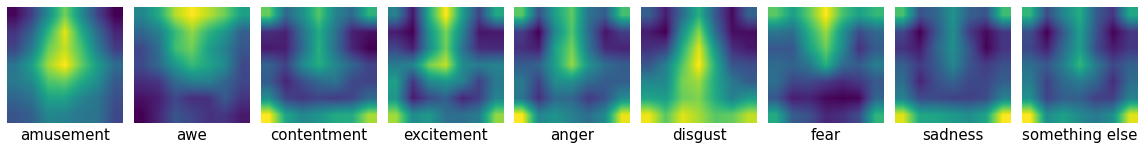

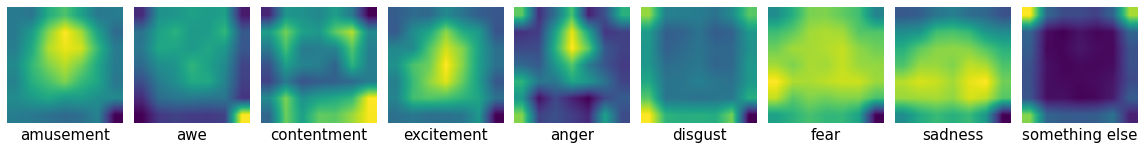

In [22]:
pp = PdfPages(res_dir+'artemis_bias.pdf')

for model_id, model_type in enumerate(model_types):
    results = {"emotion":[], "variance":[], "entropy":[]}
    plt.figure(figsize=(16, 16)) 
    subplot = 1
    for emotion, emotion_features in emotion_dicts[model_type].items():
       
        emotion_features = torch.HalfTensor(emotion_features).unsqueeze(dim=0).to(device)
        var = np.zeros((len(image_list)))
        entropy = np.zeros((len(image_list)))

        


        for id_, image in enumerate(image_list):

            image = image.unsqueeze(0).to(device)

            label_dict = {}
            for key, val in ARTEMIS_EMOTIONS.items():
                label_dict[key] = round(float(label_list[id_][val].item()), 4)


            if model_type=="ViT":
                relevance, _ = vit_relevance(image.type(model_vit.dtype), emotion_features, model_vit.visual, device)

            else:
                relevance, _ = rn_relevance(image.type(model_rn.dtype), emotion_features, model_rn.visual, GradCAM, device)

            var[id_] = ndimage.variance(relevance)
            entropy[id_] = shannon_entropy(relevance)
            
            relevance = np.expand_dims(relevance, axis=0)

            if id_ == 0:
                attentions = relevance
            else:
                attentions = np.concatenate((attentions, relevance), axis=0)


        mean = np.mean(attentions, axis=0)
        mean = np.float32(mean/np.max(mean))
        
        var = np.mean(var)
        entropy = np.mean(entropy)
        
        results["emotion"].append(emotion)
        results["variance"].append(var)
        results["entropy"].append(entropy)
       
          

        plt.subplot(1,9,subplot)
        subplot+=1
        plt.imshow(mean)
        plt.axis('off')
        plt.tight_layout()
        plt.title(emotion, **font,y=-0.20)

    plt.savefig(res_dir+model_type+'_mean.png')
    pp.savefig()
    
    results = pd.DataFrame(data=results)
    print(results)
    results.to_csv(res_dir+model_type+".csv")

pp.close()